In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

2024-03-21 16:54:49.100163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
seed = 1
np.random.seed(seed)
import tensorflow as tf

In [3]:
from stuff.callbacks import all_callbacks
from stuff import plotting

In [4]:
tf.random.set_seed(seed)

In [5]:
from scripts import dataset

In [6]:
bkg = dataset.load_dataset(dataset='NuGun_preprocessed.h5', key='full_data_cyl')
sig = dataset.load_dataset(dataset='BSM_preprocessed.h5', key='ggXToYYTo2Mu2E_m18')

In [7]:
x = np.concatenate((bkg, sig))
y = np.concatenate((np.zeros((len(bkg), 1)), np.ones((len(sig), 1))))


In [8]:
np.shape(y)

(10048853, 1)

In [9]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

/Users/jessicaprendi/opt/anaconda3/envs/SP/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1


In [20]:
model = Sequential()
model.add(Dense(64, input_shape=(99,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(64, name='fc4', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu4'))
model.add(Dense(2, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

In [21]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_2',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_2/KERAS_check_best_model.h5')

Epoch 1/30
   1/5888 [..............................] - ETA: 2:37:01 - loss: 0.7539 - accuracy: 0.9307WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 0.0042s). Check your callbacks.


5883/5888 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9812
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 0.07620, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.07620, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

5888/5888 [==============================] - 27s 4ms/step - loss: 0.0912 - accuracy: 0.9813 - val_loss: 0.0762 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 2/30
5887/5888 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9816
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 0.07620 to 0.07486, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.07620 to 0.07486, saving model to model_2/KERAS_check_best_model_weigh

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

62806/62806 [==============================] - 65s 1ms/step
Accuracy: 0.9817934481092622


In [23]:
#_ = plotting.makeRoc(y_test, y_keras, le.classes_)

In [24]:
np.argmax(y_keras, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
from sklearn.metrics import roc_curve, auc

In [26]:
np.shape(y_test)

(2009771, 2)

In [27]:
#labels = np.concatenate((np.ones(len(score_1)), np.zeros(len(score_0))))
#all = np.concatenate((score_1, score_0))
FPR, TPR, _ = roc_curve(y_score=np.max(y_keras, axis=1), y_true=y_test[:,0])
AUC = auc(FPR, TPR)

In [28]:
np.shape(y_test)

(2009771, 2)

(1e-06, 1.05)

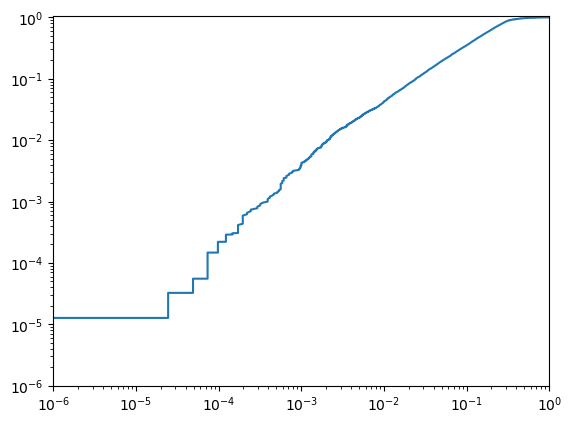

In [29]:
plt.plot(FPR, TPR)
plt.semilogx()
plt.semilogy()
plt.xlim([10**-(6), 1.0])
plt.ylim([10**-(6), 1.05])

In [30]:
AUC

0.8253634008922305